In [1]:
from hnn_core import calcium_model, read_params, simulate_dipole, average_dipoles
from hnn_core.viz import plot_dipole
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
import pickle
import numpy as np
from hnn_core import MPIBackend

In [2]:
# load participant data 
df = pd.read_csv('HNN_data_TEP_dipole_0_300.txt', sep = ' ')
data = [line.split('\t') for line in df.iloc[:,0].tolist()]

partic_data = []
partic_data.append([float(x[0]) for x in data])
partic_data.append([float(x[1]) for x in data])

# load original params
fparams = "TEP_from_def_Liz_2newInputs_optimized.param"
original_params = read_params(fparams)

# load params from V2 param file
with open('param_files/net_TEP_calcium_params.pkl', 'rb') as f:
    V2_TEP_params = pickle.load(f)

# load params from V3 param file
with open('param_files/net_TEP_calcium_params_v3.pkl', 'rb') as f:
    V3_TEP_params = pickle.load(f)

In [3]:
def make_net_and_simulate(params, n_trials = 2, tstop=None):
    # make nets
    net = calcium_model(params=params, add_drives_from_params=True)

    # simulate dipoles
    if tstop is not None:
        with MPIBackend(n_procs=n_trials, mpi_cmd='mpiexec'):
            dpl = simulate_dipole(net, tstop=tstop, n_trials=n_trials)
    else: 
        with MPIBackend(n_procs=n_trials, mpi_cmd='mpiexec'):
            dpl = simulate_dipole(net, tstop=params["tstop"], n_trials=n_trials)
    return dpl, net

In [4]:
def scale_and_smooth(dpls_list, window_len=10, scaling_factor=1):
    dpl_smoothed_list = [deepcopy(dpl) for dpl in dpls_list]
    for dpl in dpl_smoothed_list:
        for dpl_trial in dpl:
            dpl_trial.smooth(window_len).scale(scaling_factor)
    return dpl_smoothed_list

In [ ]:
def make_plot(dpls, nets, scalars, data_scale=4, tstop=320, title_list = None, trial_idx = 0):
    for i in range(len(dpls)):
        fig, axes = plt.subplots(3, 2, sharex=True, figsize=(16, 12), constrained_layout=True)

        # plot 1: drives
        nets[i].cell_response.plot_spikes_hist(ax=axes[0][0], spike_types=['evprox', 'evdist'], trial_idx=trial_idx, show=False)

        # plot 2: cell response
        # nets[i].cell_response.plot_spikes_hist(ax=axes[1][0], spike_types=['L2_pyramidal','L2_basket'], trial_idx=trial_idx, show=False)
        nets[i].cell_response.plot_spikes_hist(ax=axes[1][0], spike_types=['L5_pyramidal', 'L2_pyramidal', 'L5_basket', 'L2_basket', ], trial_idx=trial_idx, show=False)

        # plot 3: cell spiking
        nets[i].cell_response.plot_spikes_raster(ax=axes[2][0], trial_idx=trial_idx, show=False)

        # plot 4: dipole, agg and data 
        # plot_dipole(dpls[i], ax = axes[0][1], layer='agg', show=False)
        plot_dipole(dpls[i], ax = axes[0][1], layer='agg', show=False, average=True)
        axes[0][1].plot(np.array(partic_data[0][:tstop]), np.array(partic_data[1][:tstop])*data_scale)
        
        ymin, ymax = axes[0][1].get_ylim()

        # plot 5: dipole, layer 2/3
        plot_dipole(dpls[i], ax = axes[1][1], layer='L2', show=False)
        axes[1][1].set_ylim(ymin, ymax)

        # plot 6: dipole, layer 5
        plot_dipole(dpls[i], ax = axes[2][1], layer='L5', show=False)
        axes[2][1].set_ylim(ymin, ymax)
        axes[0][1].set_xlim(0,tstop)

        if title_list is None:
            fig.suptitle(f'scalar {scalars[i]}')
        else:
            fig.suptitle(title_list[i])

In [6]:
def simulate_from_params(params_list, n_trials=2):
    dpls = []
    nets = []
    for params in params_list:
        dpl, net = make_net_and_simulate(params,n_trials=n_trials)
        dpls.append(dpl)
        nets.append(net)
    smoothed_dpls = scale_and_smooth(dpls)
    return nets, smoothed_dpls

In [9]:
v2_dpl, v2_net = make_net_and_simulate(V2_TEP_params, n_trials = 3)

MPI will run 3 trial(s) sequentially by distributing network neurons over 3 processes.
numprocs=3
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
Loadin

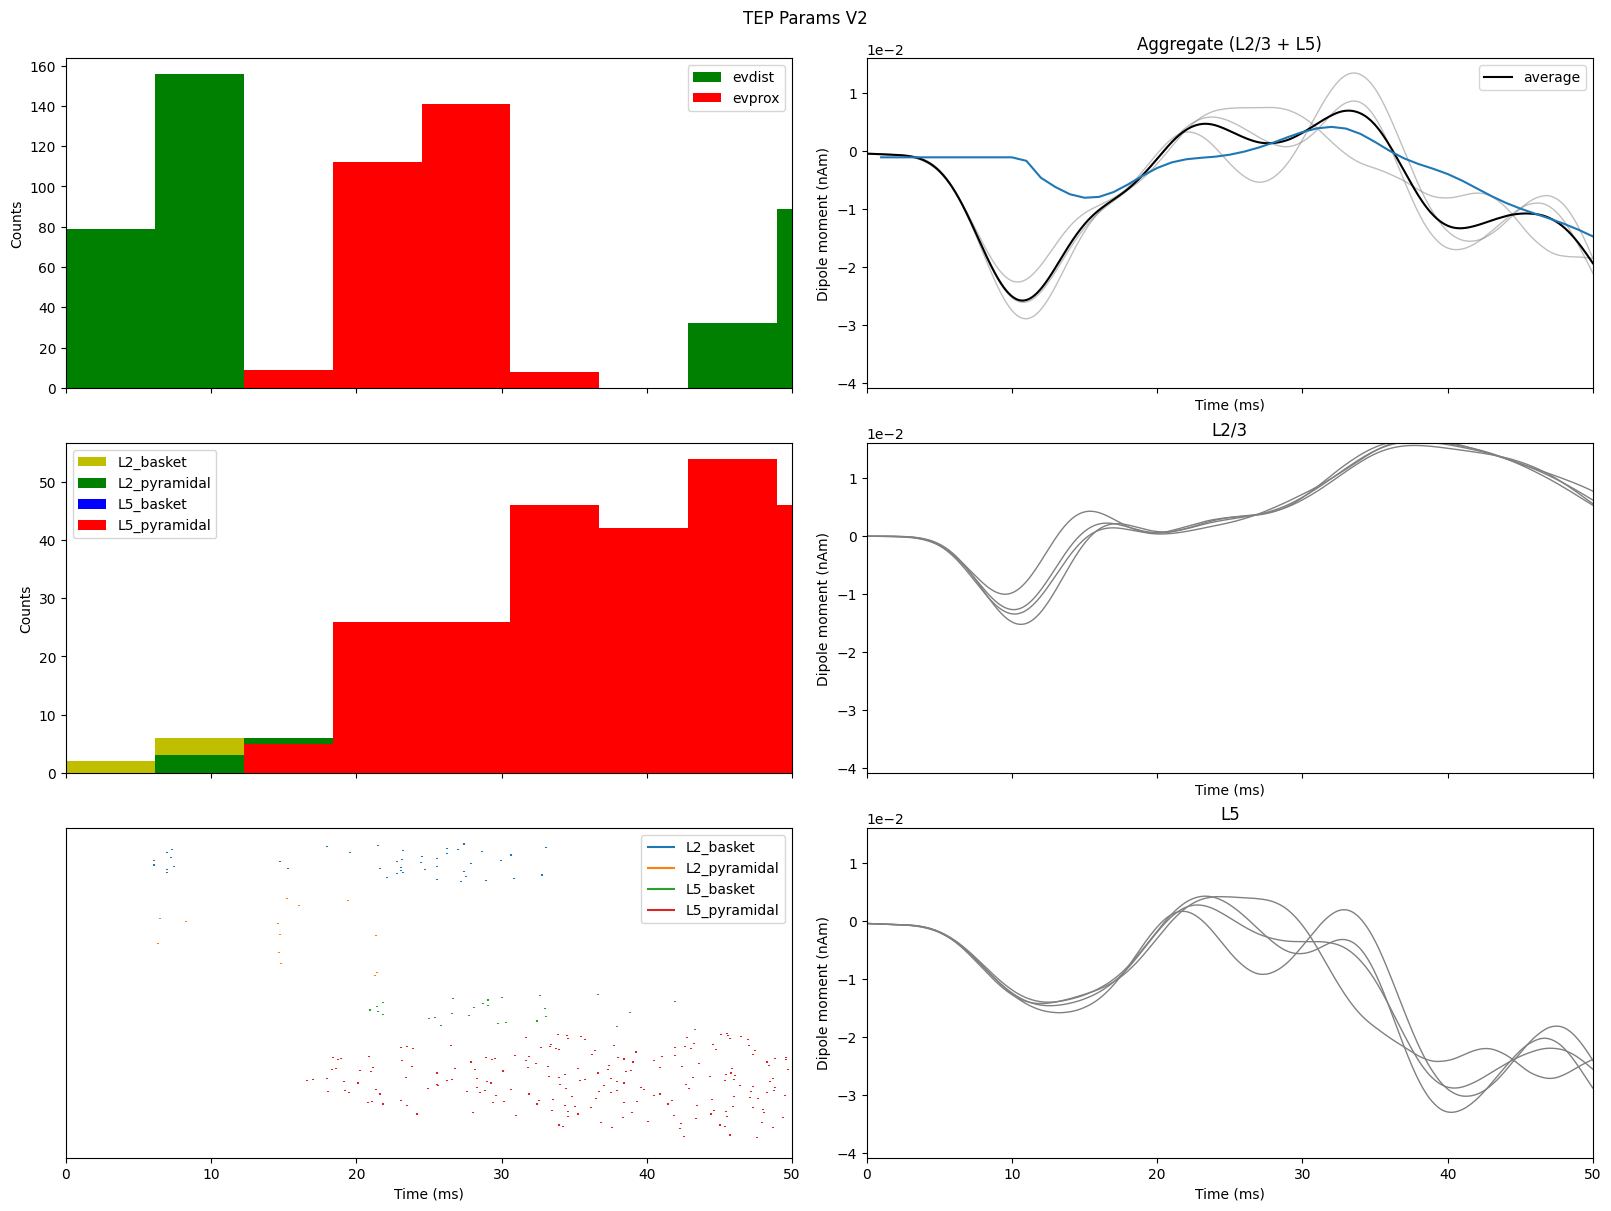

In [26]:
smoothed_v2_dpl = scale_and_smooth([v2_dpl], window_len=10)
make_plot(smoothed_v2_dpl, [v2_net], title_list=['TEP Params V2'], scalars=None, tstop=50)

MPI will run 3 trial(s) sequentially by distributing network neurons over 3 processes.
numprocs=3
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
Loadin

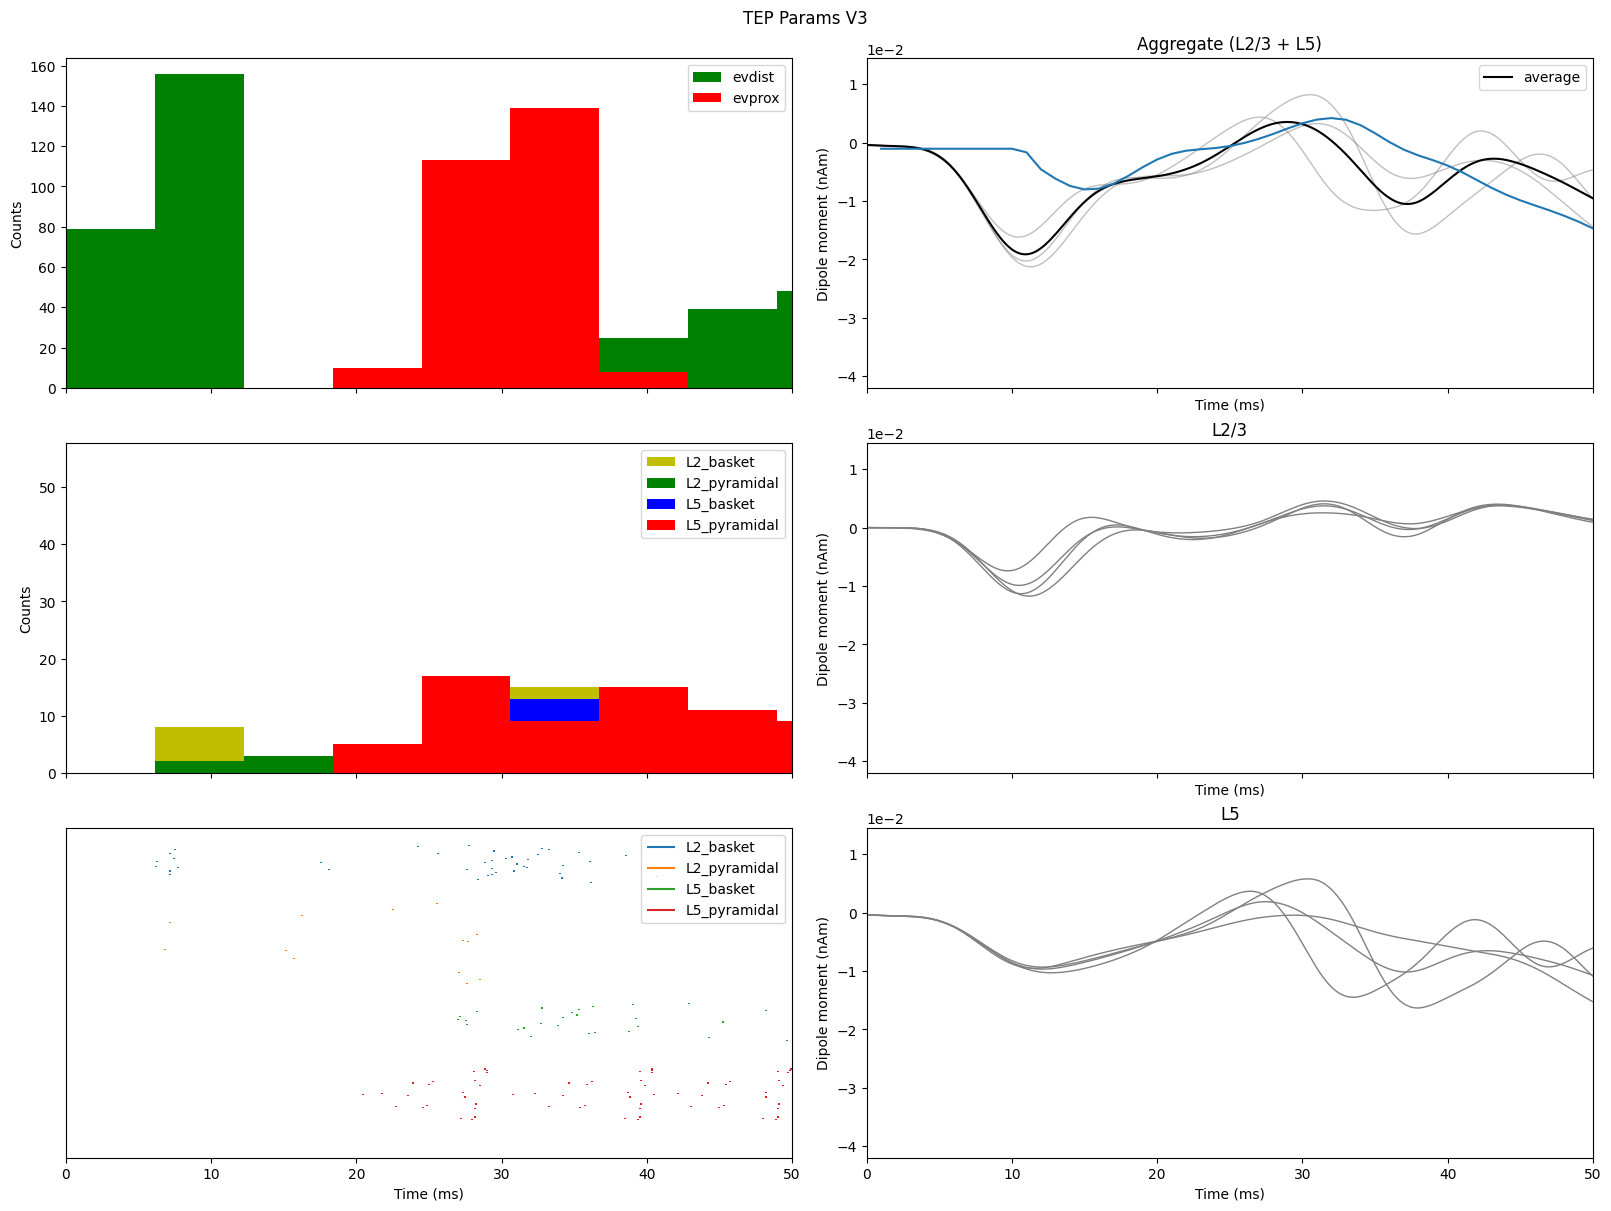

In [25]:
v3_dpl, v3_net = make_net_and_simulate(V3_TEP_params, n_trials = 3)
smoothed_v3_dpl = scale_and_smooth([v3_dpl], window_len=10)
make_plot(smoothed_v3_dpl, [v3_net], title_list=['TEP Params V3'], scalars=None, tstop=50)